# Recommender System - Final Project

The objective of this project is to build a recommendation engine to predict what restaurants customers are most likely to order from given the customer location, restaurant information, and the customer order history.

You should imagine that this is a client project and that you are working with a team of data scientists to build a recommendation engine. You will be expected to present your work to the client and to the data science team.

This solution will allow your client, an app-based food delivery service, to customise restaurant recommendations for each of their customers and ensure a more positive overall user experience.

In [101]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

There are ~$10,000$ customers in the test set. These are the customers you will need to recommend a vendor to. Each customer can order from multiple locations, identified by the variable `LOC_NUM`.

There are ~$35,000$ customers in the train set.
Some of these customers have made orders at at least one of $100$ vendors.

* `test_customers.csv`- customer id’s in the test set.
* `test_locations.csv` - latitude and longitude for the different locations of each customer.
* `train_locations.csv` - customer id’s in the test set.
* `train_customers.csv` - latitude and longitude for the different locations of each customer.
* `orders.csv` - orders that the customers `train_customers.csv` from made.
* `vendors.csv` - vendors that customers can order from.
* `VariableDefinitions.txt` - Variable definitions for the datasets
* `SampleSubmission.csv` - is an example of what your submission file should look like. The order of the rows does not matter, but the names of CID X LOC_NUM X VENDOR must be correct. The column "target" is your prediction.

## Discover the data

In [3]:
path_test_customers = 'data/test_customers.csv'
path_test_locations = 'data/test_locations.csv'
path_train_customers = 'data/train_customers.csv'
path_train_locations = 'data/train_locations.csv'
path_orders = 'data/orders.csv'
path_vendors = 'data/vendors.csv'

In [4]:
df_train_customers = pd.read_csv(path_train_customers)
df_train_locations = pd.read_csv(path_train_locations)
df_test_customers = pd.read_csv(path_test_customers)
df_test_locations = pd.read_csv(path_test_locations)
df_orders = pd.read_csv(path_orders)
df_vendors = pd.read_csv(path_vendors)

C:\Users\chars\AppData\Local\Temp\ipykernel_7384\1713450253.py:5: DtypeWarning: Columns (15,16,18,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  df_orders = pd.read_csv(path_orders)


In [12]:
print('df_train_customers.shape: ', df_train_customers.shape)
df_train_customers.head(5)

df_train_customers.shape:  (34674, 8)


,akeed_customer_id,gender,dob,status,verified,language,created_at,updated_at
0,TCHWPBT,Male,NaN,1,1,EN,2018-02-07 19:16:23,2018-02-07 19:16:23
1,ZGFSYCZ,Male,NaN,1,1,EN,2018-02-09 12:04:42,2018-02-09 12:04:41
2,S2ALZFL,Male,NaN,0,1,EN,2018-03-14 18:31:43,2018-03-14 18:31:42
3,952DBJQ,Male,NaN,1,1,EN,2018-03-15 19:47:07,2018-03-15 19:47:07
4,1IX6FXS,Male,NaN,1,1,EN,2018-03-15 19:57:01,2018-03-15 19:57:01


Information on the customers in the training set. 


- **akeed_customer_id**: Unique customer ID, used in train_locations and train_orders
- **gender**: Customer gender
- **dob**: Birth Year (if entered)
- **status** and **verified**: Account status
- **language**: Chosen language
- **Created_at** and **updated_at**: dates when account was created/updated

In [11]:
print(df_train_locations.shape)
df_train_locations.head(5)

(59503, 5)


,customer_id,location_number,location_type,latitude,longitude
0,02SFNJH,0,NaN,1.682392,-78.789737
1,02SFNJH,1,NaN,1.679137,0.766823
2,02SFNJH,2,NaN,-0.498648,0.661241
3,RU43CXC,0,Home,0.100853,0.438165
4,BDFBPRD,0,NaN,2.523125,0.733464


In [14]:
df_train_locations[df_train_locations['customer_id'] == 'TCHWPBT']

,customer_id,location_number,location_type,latitude,longitude
8632,TCHWPBT,0,Work,-96.407538,-67.197291
8633,TCHWPBT,1,Home,-96.645619,-67.169154
8634,TCHWPBT,2,NaN,-0.128673,-78.575702


Each customer orders from one or more locations. Each is assigned a location number. 

- **customer_id**: The unique customer ID 
- **location_number**: Location number (most customers have one or two)
- **location_type**: Home, Work, Other or NA
- **Latitude** and **longitude**: Not true latitude and longitude - locations have been masked, but nearby locations remain nearby in the new reference frame and can thus be used for clustering. However, not all locations are useful due to GPS errors and missing data - you may want to treat outliers separately.

In [15]:
print(df_orders.shape)
df_orders.head(5)

(135303, 26)


,akeed_order_id,customer_id,item_count,grand_total,payment_mode,promo_code,vendor_discount_amount,promo_code_discount_percentage,is_favorite,is_rated,...,driver_accepted_time,ready_for_pickup_time,picked_up_time,delivered_time,delivery_date,vendor_id,created_at,LOCATION_NUMBER,LOCATION_TYPE,CID X LOC_NUM X VENDOR
0,163238.0,92PEE24,1.0,7.6,2,NaN,0.0,NaN,NaN,No,...,NaN,NaN,NaN,NaN,2019-07-31 05:30:00,105,2019-08-01 05:30:16,0,NaN,92PEE24 X 0 X 105
1,163240.0,QS68UD8,1.0,8.7,1,NaN,0.0,NaN,NaN,No,...,NaN,NaN,NaN,NaN,2019-07-31 05:30:00,294,2019-08-01 05:31:10,0,Work,QS68UD8 X 0 X 294
2,163241.0,MB7VY5F,2.0,14.4,1,NaN,0.0,NaN,NaN,No,...,NaN,NaN,NaN,NaN,2019-07-31 05:30:00,83,2019-08-01 05:31:33,0,NaN,MB7VY5F X 0 X 83
3,163244.0,KDJ951Y,1.0,7.1,1,NaN,0.0,NaN,NaN,No,...,NaN,NaN,NaN,NaN,2019-07-31 05:30:00,90,2019-08-01 05:34:54,0,Home,KDJ951Y X 0 X 90
4,163245.0,BAL0RVT,4.0,27.2,1,NaN,0.0,NaN,NaN,No,...,NaN,NaN,NaN,NaN,2019-07-31 05:30:00,83,2019-08-01 05:35:51,0,Work,BAL0RVT X 0 X 83


In [18]:
df_orders.columns

Index(['akeed_order_id', 'customer_id', 'item_count', 'grand_total',
       'payment_mode', 'promo_code', 'vendor_discount_amount',
       'promo_code_discount_percentage', 'is_favorite', 'is_rated',
       'vendor_rating', 'driver_rating', 'deliverydistance', 'preparationtime',
       'delivery_time', 'order_accepted_time', 'driver_accepted_time',
       'ready_for_pickup_time', 'picked_up_time', 'delivered_time',
       'delivery_date', 'vendor_id', 'created_at', 'LOCATION_NUMBER',
       'LOCATION_TYPE', 'CID X LOC_NUM X VENDOR'],
      dtype='object')

This is a record of all orders made by customers in the train set from the vendors included in this competition. Each order contains:
- **akeed_order_id**: The order ID used internally - can be ignored
- **customer_id**: The customer making the order, used to link with customer info
- **item_count**: how many items were in the order
- **grand_total**: total cost


Payment related columns: 'payment_mode', 'Promo_code', 'vendor_discount_amount', 'Promo_code_discount_percentage'

Vendor related columns:  'is_favorite', 'is_rated', 'vendor_rating', 'driver_rating',


Order details:  'deliverydistance', 'preparationtime',  'delivery_time', 'order_accepted_time',
 'driver_accepted_time', 'ready_for_pickup_time', 'picked_up_time', 'delivered_time',
 'delivery_date','created_at'


In [16]:
print(df_vendors.shape)
df_vendors.head(5)

(100, 59)


,id,authentication_id,latitude,longitude,vendor_category_en,vendor_category_id,delivery_charge,serving_distance,is_open,OpeningTime,...,open_close_flags,vendor_tag,vendor_tag_name,one_click_vendor,country_id,city_id,created_at,updated_at,device_type,display_orders
0,4,118597.0,-0.588596,0.754434,Restaurants,2.0,0.0,6.0,1.0,11:00AM-11:30PM,...,1.0,"2,4,5,8,91,22,12,24,16,23","Arabic,Breakfast,Burgers,Desserts,Free Deliver...",Y,1.0,1.0,2018-01-30 14:42:04,2020-04-07 15:12:43,3,1
1,13,118608.0,-0.471654,0.744470,Restaurants,2.0,0.7,5.0,1.0,08:30AM-10:30PM,...,1.0,"4,41,51,34,27,15,24,16,28","Breakfast,Cakes,Crepes,Italian,Pasta,Pizzas,Sa...",Y,1.0,1.0,2018-05-03 12:32:06,2020-04-05 20:46:03,3,1
2,20,118616.0,-0.407527,0.643681,Restaurants,2.0,0.0,8.0,1.0,08:00AM-10:45PM,...,1.0,"4,8,91,10","Breakfast,Desserts,Free Delivery,Indian",Y,1.0,1.0,2018-05-04 22:28:22,2020-04-07 16:35:55,3,1
3,23,118619.0,-0.585385,0.753811,Restaurants,2.0,0.0,5.0,1.0,10:59AM-10:30PM,...,1.0,"5,8,30,24","Burgers,Desserts,Fries,Salads",Y,1.0,1.0,2018-05-06 19:20:48,2020-04-02 00:56:17,3,1
4,28,118624.0,0.480602,0.552850,Restaurants,2.0,0.7,15.0,1.0,11:00AM-11:45PM,...,1.0,5,Burgers,Y,1.0,1.0,2018-05-17 22:12:38,2020-04-05 15:57:41,3,1


In [17]:
df_vendors.columns

Index(['id', 'authentication_id', 'latitude', 'longitude',
       'vendor_category_en', 'vendor_category_id', 'delivery_charge',
       'serving_distance', 'is_open', 'OpeningTime', 'OpeningTime2',
       'prepration_time', 'commission', 'is_akeed_delivering',
       'discount_percentage', 'status', 'verified', 'rank', 'language',
       'vendor_rating', 'sunday_from_time1', 'sunday_to_time1',
       'sunday_from_time2', 'sunday_to_time2', 'monday_from_time1',
       'monday_to_time1', 'monday_from_time2', 'monday_to_time2',
       'tuesday_from_time1', 'tuesday_to_time1', 'tuesday_from_time2',
       'tuesday_to_time2', 'wednesday_from_time1', 'wednesday_to_time1',
       'wednesday_from_time2', 'wednesday_to_time2', 'thursday_from_time1',
       'thursday_to_time1', 'thursday_from_time2', 'thursday_to_time2',
       'friday_from_time1', 'friday_to_time1', 'friday_from_time2',
       'friday_to_time2', 'saturday_from_time1', 'saturday_to_time1',
       'saturday_from_time2', 'saturday

- **vendor_id**: the unique ID of the vendor
- **LOCATION_NUMBER**: The location number specifies which of the customers locations the delivery was made to
- **LOCATION_TYPE**: same as location type in the train_locations table
- **CID X LOC_NUM X VENDOR**: Customer ID, location number and Vendor number as used in the submission file.

### Interesting users
Can be interresting to look at the users that have rated the most orders.

In [62]:
interesting_users = df_orders[df_orders['is_rated'] == 'Yes']\
                        .groupby('customer_id').count()[['item_count', 'grand_total', 'is_rated', 'vendor_rating']]\
                        .sort_values(by='item_count', ascending=False)
interesting_users = interesting_users[interesting_users['item_count'] >= 10]
interesting_users


,item_count,grand_total,is_rated,vendor_rating
customer_id,,,,
XW90EAP,71,78,78,78
2JJAO46,67,68,68,68
DGRUO7S,54,54,54,54
HJFTTGW,54,54,54,54
VDEJEMP,47,47,47,47
...,...,...,...,...
8RZVIZL,10,10,10,10
FBMYILI,10,10,10,10
BQYD60X,10,11,11,11


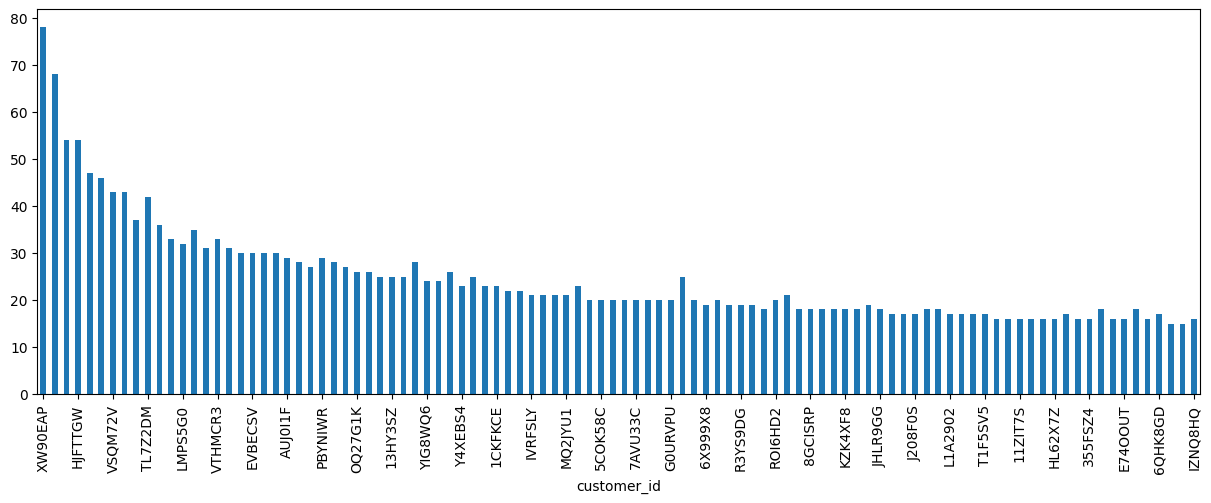

In [63]:
interesting_users['is_rated'][:100].plot(kind='bar', figsize=(15, 5))
plt.xticks(np.arange(0, 100, 3))
plt.show()

### Interesting vendors
It can be also interesting to look at the vendors that have the most orders.

In [86]:
interesting_vendor = df_orders[df_orders['is_rated'] == 'Yes']\
                        .groupby('vendor_id').mean()[['item_count', 'grand_total', 'vendor_rating']]\
                        .sort_values(by='vendor_rating', ascending=False)
#interesting_vendor = interesting_vendor[interesting_vendor['item_count'] >= 10]
interesting_vendor

C:\Users\chars\AppData\Local\Temp\ipykernel_7384\2727587282.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  .groupby('vendor_id').mean()[['item_count', 'grand_total', 'vendor_rating']]\


,item_count,grand_total,vendor_rating
vendor_id,,,
303,2.112500,14.297674,4.790698
216,1.403756,11.204695,4.755869
115,2.000000,10.529167,4.750000
295,2.039062,12.984375,4.742188
294,1.882353,17.852632,4.736842
...,...,...,...
201,1.664000,10.286154,3.923077
149,1.381818,10.137500,3.910714
304,2.857143,15.714286,3.714286


## Build a model
Now we have an overview of the data, we can start building a model. We will use the following approach:
- First create a matrix user x vendor with the ratings of the users for the vendors. We will use the ratings of the orders as ratings.
- Then we will use this matrix to train a model that predicts the ratings of the users for the vendors. We will use a collaborative filtering approach. We can use ALS or Funck SVD for this.
- We will use the model to predict the ratings of the users for the vendors in the test set.
- Finally we will filter by ratings and the capacity of the vendors to deliver to the location of the user.

In [100]:
# Create a matrix user x vendor

ratings_matrix = df_orders[df_orders['is_rated'] == 'Yes'][df_orders['customer_id'].isin(interesting_users.index)]
ratings_matrix = ratings_matrix.pivot_table(index="customer_id", columns="vendor_id", values="vendor_rating", aggfunc='mean').fillna(0)
ratings_matrix

C:\Users\chars\AppData\Local\Temp\ipykernel_7384\1216079261.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ratings_matrix = df_orders[df_orders['is_rated'] == 'Yes'][df_orders['customer_id'].isin(interesting_users.index)]


vendor_id,4,13,20,23,28,33,43,44,55,66,...,679,681,841,843,845,846,849,855,856,858
customer_id,,,,,,,,,,,,,,,,,,,,,
00OT8JX,5.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,5.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
0HITBVB,1.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,4.000000,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0LFS2HM,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0WC3Z55,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0
0WPRRMJ,0.0,0.0,0.0,0.0,3.75,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,3.8,3.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZV19364,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,4.8,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ZVFPRG1,0.0,5.0,0.0,0.0,0.00,5.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ZVH5WD9,5.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
def build_model(latent_dim, learning_rate, ratings_matrix):
    latent_dim = 3
    learning_rate = 0.01

    # Définition du modèle Funk SVD
    num_users, num_items = ratings_matrix.shape
    input_users = tf.keras.layers.Input(shape=(1,))
    input_items = tf.keras.layers.Input(shape=(1,))
    embed_users = tf.keras.layers.Embedding(num_users, latent_dim)(input_users)
    embed_items = tf.keras.layers.Embedding(num_items, latent_dim)(input_items)
    dot_product = tf.keras.layers.Dot(axes=2)([embed_users, embed_items])
    flatten = tf.keras.layers.Flatten()(dot_product)
    model = tf.keras.Model(inputs=[input_users, input_items], outputs=flatten)


    # Compilation du modèle
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                loss='mean_squared_error', metrics=['f1_score'])
    return model